### 전처리 노트북 2/5: 변수 추가
사용법: 
- 전처리 노트북 1을 실행 후 00_electric_train_polished.csv, 00_electric_test_polished.csv 를 asset_path에 저장 
- https://data.kma.go.kr/community/board/selectBoardList.do?bbrdTypeNo=4&pgmNo=92 에서 최근 격자정보를 받은 후 asset_path/region/region_loc.csv 로 저장
- 각 셀을 순서대로 실행

결과물:
- 01_electric_train_features.csv
- 01_electric_test_features.csv

In [1]:
# Standard library imports
from pathlib import Path
from datetime import datetime
import json
import pickle

# Data handling and preprocessing
import pandas as pd
import numpy as np
import pytz
import requests
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# Geospatial data handling
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

# Parallel processing
from multiprocessing import Pool

from matplotlib import cm
from collections import defaultdict
import numpy as np

# Custom imports
from pysolar.solar import get_altitude


from preprocessing_utils import Backup, get_data_paths, get_figure_path
asset_path, data_path = get_data_paths()
figure_path = get_figure_path()

train_polished_asset_path = Path(asset_path, '00_electric_train_polished.csv')
test_polished_asset_path  = Path(asset_path, '00_electric_test_polished.csv')

SAVE = False

___

#### 한번 Polishing 된 데이터를 다시 불러오는 부분! 그리고 datetime은 날짜 처리의 편의성을 위하여 문자열에서 Datetime object로 바꾸어준다.

In [2]:
train_data = pd.read_csv(train_polished_asset_path)
test_data = pd.read_csv(test_polished_asset_path)

train_data['datetime'] = pd.to_datetime(train_data['datetime'])
test_data['datetime'] = pd.to_datetime(test_data['datetime'])

In [3]:
train_data['date'] = train_data['datetime'].dt.date
test_data['date'] = test_data['datetime'].dt.date

____

### 00. Train Data에 대해 avgload 변수 추가

In [4]:
train_data['avg_load'] = train_data['sum_load'] / train_data['units']
    # check whether the average_load is valid
assert train_data['avg_load'].isna().sum() == 0
assert train_data['avg_load'].isnull().sum() == 0
# also assert positiveness
assert (train_data['avg_load'] < 0).sum() == 0

____

### 01. 한국의 공휴일을 알려주는 변수 추가
참고: https://velog.io/@qlgks1/python-%EB%82%A0%EC%A7%9C%EC%99%80-%EC%8B%9C%EA%B0%84-%EB%8B%A4%EB%A3%A8%EA%B8%B0-datetime-%EB%AA%A8%EB%93%88-%ED%95%B4%EB%B6%80-%EA%B7%B8%EB%A6%AC%EA%B3%A0-third-party

In [5]:
def to_strdate(x):
    x = str(x)
    return '-'.join([x[:4], x[4:6], x[6:]])

year_holiday_dict = {}

for year in [2020, 2021, 2022, 2023]:
    key = 'bom%2BTHr14TDIPGjfJl7mrv2YCDtzzrSC0CAm7yORlly1d%2FeJqPAeKib8%2FuJgWKg2qxru2UoNqQKJcLFL6aT2oQ%3D%3D'
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo?_type=json&numOfRows=50&solYear=' + str(year) + '&ServiceKey=' + str(key)
    response = requests.get(url)
    if response.status_code == 200:
        json_ob = json.loads(response.text)
        holidays_data = json_ob['response']['body']['items']['item']
        dataframe = pd.json_normalize(holidays_data)

    year_holiday_dict[year] = dataframe['locdate'].apply(to_strdate).values

_holiday_list = []
for year in year_holiday_dict:
    _holiday_list.extend(year_holiday_dict[year])

holiday_list = []
for date in _holiday_list:
    # to datetime.date
    holiday_list.append(pd.to_datetime(date).date())

for data in [train_data, test_data]:
    data['holiday'] = 0
    data.loc[data['date'].isin(holiday_list), 'holiday'] = 1

____

### 02. num을 통한 격자 번호 및 위경도 계산

https://fronteer.kr/service/kmaxy

In [6]:
# 파라미터 설정
RE = 6371.00877  # 지구 반경(km)
GRID = 5.0  # 격자 간격(km)
SLAT1 = 30.0  # 투영 위도1(degree)
SLAT2 = 60.0  # 투영 위도2(degree)
OLON = 126.0  # 기준점 경도(degree)
OLAT = 38.0  # 기준점 위도(degree)
XO = 43  # 기준점 X좌표(GRID)
YO = 136  # 기준점 Y좌표(GRID)

DEGRAD = np.pi / 180.0
RADDEG = 180.0 / np.pi

re = RE / GRID
slat1 = SLAT1 * DEGRAD
slat2 = SLAT2 * DEGRAD
olon = OLON * DEGRAD
olat = OLAT * DEGRAD

sn = np.tan(np.pi * 0.25 + slat2 * 0.5) / np.tan(np.pi * 0.25 + slat1 * 0.5)
sn = np.log(np.cos(slat1) / np.cos(slat2)) / np.log(sn)
sf = np.tan(np.pi * 0.25 + slat1 * 0.5)
sf = (sf**sn) * np.cos(slat1) / sn
ro = np.tan(np.pi * 0.25 + olat * 0.5)
ro = re * sf / (ro**sn)

def calculate_lon_lat_vectorized(x, y):
    xn = x - XO
    yn = ro - y + YO
    ra = np.sqrt(xn**2 + yn**2)
    ra = np.where(sn < 0, -ra, ra)
    alat = (re * sf / ra)**(1.0 / sn)
    alat = 2.0 * np.arctan(alat) - np.pi * 0.5

    theta = np.arctan2(xn, yn)
    alon = theta / sn + olon
    lat = alat * RADDEG
    lon = alon * RADDEG
    
    return lon, lat

In [7]:
# 벡터화된 계산을 사용하여 lon, lat 열 추가
for data in [train_data, test_data]:
    NUM = data['num']
    data['x'] = ((NUM - 1) % 149 + 1)  #/ 149
    data['y'] = ((NUM - 1) // 149 + 1) #/ 253
    data['lon'], data['lat'] = calculate_lon_lat_vectorized(data['x'].values, data['y'].values)

___

### 03. 태양의 남중고도 추가 (오래걸림)

일출상태인지 일몰상태인지 결정할 수 있기 때문에 유용하다고 생각하였음.

그러나 지속적으로 실험해 본 결과 실제 성능에 미치는 영향이 크지 않다고 판단함.

In [8]:
# 함수 정의
def calculate_altitude(row):
    return get_altitude(row['lat'], row['lon'], row['datetime_mid_tzKST'])

# tqdm과 multiprocess를 사용한 함수
def apply_with_progress(dataframe, func):
    with Pool() as pool:
        results = list(tqdm(pool.imap(func, [row for _, row in dataframe.iterrows()]), total=len(dataframe)))
    return results


In [9]:
# get_altitude를 multiprocess로 적용
KST = pytz.timezone('Asia/Seoul')

for data in [train_data, test_data]:
    print('Calculating altitude for', data.shape[0], 'rows')
    # datetime 컬럼을 datetime 형식으로 변환하고 30분 더한 후 타임존 설정
    data['datetime_mid_tzKST'] = (pd.to_datetime(data['datetime']) + pd.DateOffset(minutes=30)).dt.tz_localize('UTC').dt.tz_convert(KST)
    data['altitude_raw'] = apply_with_progress(data, calculate_altitude)
    data['altitude'] = data['altitude_raw'].apply(lambda x: max(-18.0, x))

Calculating altitude for 7593360 rows


100%|██████████| 7593360/7593360 [10:05<00:00, 12540.79it/s]


Calculating altitude for 2829480 rows


100%|██████████| 2829480/2829480 [03:38<00:00, 12940.58it/s]


____

### 04. 기상 변수 추가 제작

#### Discomfort Index (불쾌지수)

#### Heat Index (열지수)
- 기온과 상대 습도를 결합하여 사람이 느끼는 체감 온도를 나타내는 지표
- https://en.wikipedia.org/wiki/Heat_index

#### Wind Chill (풍속냉각지수)
- 바람이 불 때 사람이 느끼는 체감 온도를 나타내는 지표, 바람이 강할수록 체온이 더 빠르게 떨어지므로 실제 기온보다 더 춥게 느껴짐
- https://en.wikipedia.org/wiki/Wind_chill

#### Apparaent Temperature (체감 온도)
- The Australian Apparent Temperature (AT) is a type of heat index that was used by the Australian Bureau of Meteorology
- https://www.vcalc.com/wiki/australian-apparent-temperature

In [10]:
def discomfort_index(temp, humid):
    return 9/5 * temp - 0.55 * (1 - humid / 100) * (9/5 * temp - 26) + 32

def calculate_heat_index(temp_celsius, humidity):
    # 섭씨를 화씨로 변환
    temp_fahrenheit = temp_celsius * 9 / 5 + 32   
    T = temp_fahrenheit
    RH = humidity
    # 열지수 계산 공식 (화씨 기준)
    HI = (-42.379 + 2.04901523 * T + 10.14333127 * RH - 0.22475541 * T * RH 
          - 6.83783e-3 * T**2 - 5.481717e-2 * RH**2 + 1.22874e-3 * T**2 * RH 
          + 8.5282e-4 * T * RH**2 - 1.99e-6 * T**2 * RH**2)
    # 화씨를 섭씨로 변환
    HI_celsius = (HI - 32) * 5 / 9
    return HI_celsius

def calculate_wind_chill(temp, wind):
    v = wind
    T_a = temp
    WCI = (10 * np.sqrt(v) - v + 10.5) * (33 - T_a)
    return WCI

# 체감 온도 (섭씨, %, m/s) 계산 함수
def calculate_apparent_temp(temp, humid, wind):
    e = humid / 100.0 * 6.105 * np.exp(17.27 * temp / (237.7 + temp))
    AT = temp + 0.33 * e - 0.70 * wind - 4.00
    return AT

# 변수 계산 및 추가

for data in [train_data, test_data]:
    data['dci'] = discomfort_index(data['temp'], data['humid'])
    data['hi'] = calculate_heat_index(data['temp'], data['humid'])
    data['wchi'] = calculate_wind_chill(data['temp'], data['wind'])
    data['atemp'] = calculate_apparent_temp(data['temp'], data['humid'], data['wind'])

In [11]:
corr_calculation_variables = ['temp', 'humid', 'wind', 'rain', 'tchi', 'dci', 'hi', 'wchi', 'atemp']

corr = train_data[corr_calculation_variables].corr()

#### 새로 만든 변수와 기존 기상 변수와의 상관계수

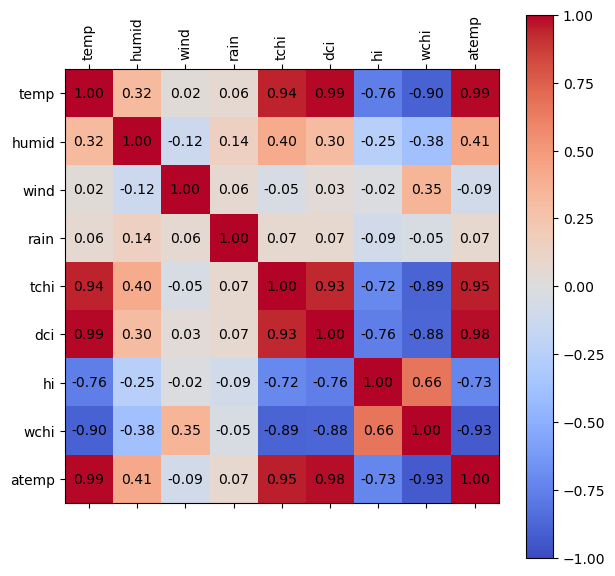

In [12]:
# corr heatmap
plt.figure(figsize=(7, 7))
plt.matshow(corr, fignum=1, cmap='coolwarm', vmin=-1, vmax=1)
# 주석 추가
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

___

### 05. 격자별 지역 분류
#### 격자 별로 위치를 확인하여 규모 별로 4개의 카테고리로 구분함

In [13]:
_train_data = train_data[['num','year', 'x', 'y', 'units']].drop_duplicates().reset_index(drop=True)
_test_data  = test_data[['num','year','x', 'y']].drop_duplicates().reset_index(drop=True)

region_data = pd.concat([_train_data, _test_data], axis=0).reset_index(drop=True)

In [14]:
loc_df = pd.read_csv(Path('./region_loc.csv'))

# = loc_df[['격자 X', '격자 Y']]
unique_XY = loc_df[['격자 X', '격자 Y']].drop_duplicates().reset_index(drop=True).values

- 먼저 각 격자에 대하여, 동네예보 격자 정보를 사용하여 NUM으로부터 X,Y 격자 위치를 얻는다. 

- 격자 지역의 행정 정보를 기상청 기상자료개방포털로부터 얻고, 이 정보를 기반으로 각 격자별로 대응되는 1단계(도/특별시/광역시), 2단계(시/군/구) 행정지역 정보들을 모두 저장하였다. 

- 만약 특정 격자에 대한 정보가 존재하지 않으면 인접한, X,Y값이 하나 차이나는 격자의 정보를 모두 저장하였다.
- https://data.kma.go.kr/community/board/selectBoardList.do?bbrdTypeNo=4&pgmNo=92

In [34]:
grouped = region_data.groupby('num')

region_df = []

for num, group in grouped:
    X, Y = group['x'].iloc[0], group['y'].iloc[0]
    
    if not [X,Y] in unique_XY.tolist():
        #print(f"num {num} is not found")
        # find nearest XY
        min_dist = 999999
        min_XY = None
        for XY in unique_XY:
            dist = np.linalg.norm([X - XY[0], Y - XY[1]])
            if dist < min_dist:
                min_dist = dist
                min_XY = [XY]
            elif dist == min_dist:
                min_XY.append(XY)

        print(f"num {num} with XY {X,Y} not found, replaced with XY {min_XY}")
    else:
        min_XY = [[X,Y]]
    
    # find for all XY in min_XY
    total = []
    for XY in min_XY:
        searched = loc_df[(loc_df['격자 X'] == XY[0]) & (loc_df['격자 Y'] == XY[1])]
        searched = searched[['1단계', '2단계']].reset_index(drop=True)
        total.append(searched)

    total_df = pd.concat(total).drop_duplicates().reset_index(drop=True)
    total_df['num'] = num

    region_df.append(total_df)

region_df = pd.concat(region_df).reset_index(drop=True)
# order columns
region_df = region_df[['num', '1단계', '2단계']]

# drop na row
region_df = region_df.dropna()

region_df.head()

num 4816 with XY (48, 33) not found, replaced with XY [array([48, 32])]
num 9609 with XY (73, 65) not found, replaced with XY [array([73, 66]), array([72, 65]), array([74, 65])]
num 11562 with XY (89, 78) not found, replaced with XY [array([89, 79]), array([89, 77]), array([88, 78])]
num 11718 with XY (96, 79) not found, replaced with XY [array([97, 79]), array([96, 78])]
num 13497 with XY (87, 91) not found, replaced with XY [array([88, 91]), array([87, 90]), array([86, 91]), array([87, 92])]
num 14258 with XY (103, 96) not found, replaced with XY [array([102,  96]), array([103,  95])]
num 16001 with XY (58, 108) not found, replaced with XY [array([ 58, 109]), array([ 58, 107]), array([ 57, 108])]
num 16011 with XY (68, 108) not found, replaced with XY [array([ 68, 107]), array([ 68, 109]), array([ 69, 108])]
num 16452 with XY (62, 111) not found, replaced with XY [array([ 63, 111]), array([ 62, 110]), array([ 61, 111])]
num 17800 with XY (69, 120) not found, replaced with XY [array([

,num,1단계,2단계
0,4816,제주특별자치도,서귀포시
1,4821,제주특별자치도,서귀포시
3,5565,제주특별자치도,제주시
4,5566,제주특별자치도,제주시
5,5567,제주특별자치도,제주시


#### 각 격자에서 얻어진 모든 1단계-2단계 행정지역을 아래와 같이 구분하였다.

- **구분 0**: 서울특별시 지역
- **구분 1**: 광역시 혹은 세종특별자치시
- **구분 2**: 특례시 (수원시, 창원시, 고양시, 용인시) , 인구 50만 이상의 도시 (50만 인구 특례를 받는 도시), 기타 "시" 단위 중 규모가 큰 도시들 선택
- **구분 3**: 나머지 지역구분

#### 위 구분을 기반으로 각 격자를 분류하였다. 
- 만약 격자가 여러 개의 구분을 가진다면 (하나의 격자가 여러개의 1단계/2단계 행정지역에 대응 가능) 빈도가 가장 높은 구분 중 숫자가 큰 구분을 선택핬다.

In [35]:
def make_category_by_stage(row):
    stage1 = row['1단계']
    stage2 = str(row['2단계'])
    priority = -1
    if stage1 == '서울특별시':
        priority = 0
    elif '광역시' in stage1 or '특별자치시' in stage1:
        priority = 1
    elif any(city in stage2 for city in ['수원시', '창원시', '고양시', '용인시']):
        priority = 2
    elif any(city in stage2 for city in ["성남시", "화성시", "청주시", "부천시", "남양주시", "천안시", "전주시", "안산시", \
                                                      "평택시", "안양시", "김해시", "시흥시", "파주시", "김포시", "포항시"]):
        priority = 3
    elif any(city in stage2 for city in [ "파주시", "의정부시", "구미시", "광주시", "아산시","원주시", "양산시", "진주시", "하남시", "춘천시",\
                                         "경주시", "강릉시", "안동시"]):
        priority = 4
    else:
        priority = 5

    priority = {
        0:0,
        1:1,
        2:2,
        3:2,
        4:2,
        5:3
    }[priority]
    
    return priority

# 우선순위 열 추가
region_df['priority'] = region_df.apply(make_category_by_stage, axis=1)

In [36]:
region_df

,num,1단계,2단계,priority
0,4816,제주특별자치도,서귀포시,3
1,4821,제주특별자치도,서귀포시,3
3,5565,제주특별자치도,제주시,3
4,5566,제주특별자치도,제주시,3
5,5567,제주특별자치도,제주시,3
...,...,...,...,...
569,19740,강원특별자치도,춘천시,2
570,19741,강원특별자치도,춘천시,2
571,19878,경기도,동두천시,3
573,19890,강원특별자치도,춘천시,2


(array([ 23.,  86., 140.,  94.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

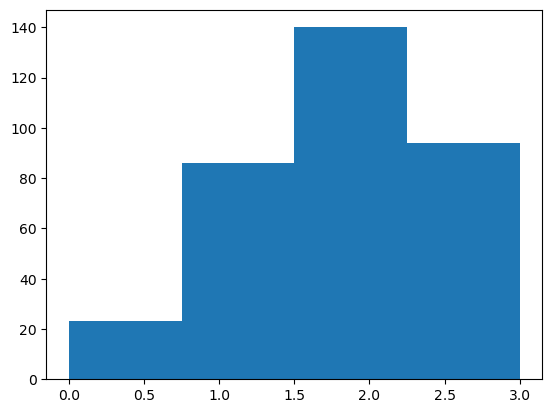

In [37]:
num_to_priority = {}

for num, group in region_df.groupby('num'):
    priorities = group[['1단계', '2단계', 'priority']].drop_duplicates().reset_index(drop=True)
    if len(priorities['priority'].unique()) > 1:
        #print(f"num {num} has multiple priorities {priorities}")
        # set priority to the most frequent one, and if there are multiple most frequent ones, set to the largest one
        priority_counts = priorities['priority'].value_counts()
        max_count = priority_counts.max()
        most_frequent_priorities = priority_counts[priority_counts == max_count].index
        num_priority = max(most_frequent_priorities)
    else:
        num_priority = priorities['priority'].iloc[0]
    #print(f"num {num} assigned priority {num_priority}")

    num_to_priority[num] = num_priority

plt.hist(num_to_priority.values(), bins=4)

In [18]:
region_data['priority'] = region_data['num'].map(num_to_priority)

region_data.head()

,num,year,x,y,units,priority
0,4821,2021,53,33,11.0,3
1,5565,2020,52,38,58.0,3
2,5565,2021,52,38,49.0,3
3,5565,2022,52,38,32.0,3
4,5566,2020,53,38,19.0,3


In [38]:
region_data['lon'], region_data['lat'] = calculate_lon_lat_vectorized(region_data['x'].values, region_data['y'].values)

In [41]:
year_grouped_region_data = region_data[['year','num','lon','lat','priority']].groupby('year')

In [43]:
figure_region_path = Path(figure_path, 'region')
figure_region_path.mkdir(parents=True, exist_ok=True)

for year in [2020, 2021, 2022]:
    year_data = year_grouped_region_data.get_group(year)
    year_data.to_csv(Path(figure_region_path, f'region_data_{year}.csv'), index=False)

____

priority 0
priority 1
priority 2
priority 3


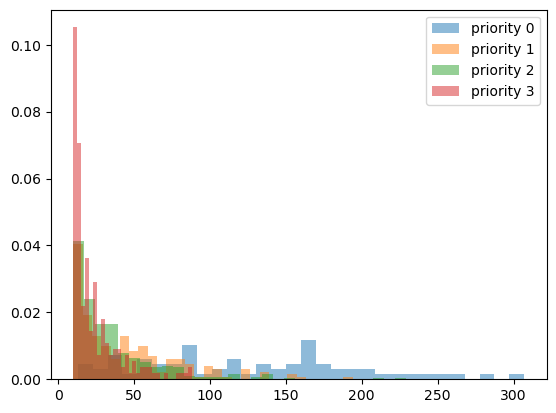

In [19]:
# units statsitis per priority
grouped = region_data.groupby('priority')

for priority, group in grouped:
    print(f"priority {priority}")
    plt.hist(group['units'], bins=30, alpha=0.5, label=f"priority {priority}", density=True)

plt.legend()

___

### 06. Test Data의 주택수 예측

각 격자에서 2020, 2021, 2022 년도 주택수를 log 변환한 후 선형 보간으로 2023 년도 주택수의 log값을 예측하였다.

이렇게 한 이유는 주택수를 직접 관찰해봤는데 주택수 자체에 대한 (log를 안씌운 상태에서) 선형 변환의 결과가 너무 변화가 크기 때문이었음

In [20]:
# priority 별로 2년의 데이터가 없는 경우 평균 unit수 계산
grouped = region_data[region_data['year'] != 2023].groupby('priority')

unique_units_by_priority = defaultdict(list)
for priority, group in grouped:
    for num, group in group.groupby('num'):
        if len(group['year'].unique()) < 2:
            unique_units_by_priority[priority].extend(group['units'].unique())

unique_units_by_priority = {priority: np.round(np.mean(units)).astype(int) for priority, units in unique_units_by_priority.items()}

In [21]:
unique_units_by_priority

{1: 13, 2: 13, 3: 11}

In [22]:
from scipy import interpolate

grouped = region_data.groupby('num')

num_to_units_2023 = {}
for num, group in grouped:
    unique_years = group['year'].unique()
    num_priority = num_to_priority[num]
    unit_arr= np.full(4, np.nan)
    for year in unique_years:
        if year == 2023: continue
        unit_arr[year-2020] = group[group['year'] == year]['units'].mean()

    unit_arr = np.log(unit_arr)

    if np.all(np.isnan(unit_arr)):
        #print(f"num {num} has no data")
        unit_arr[3] = unique_units_by_priority[num_priority]

    else:
        non_nan_idx = np.where(~np.isnan(unit_arr))[0]
        non_nan_val = unit_arr[non_nan_idx]
        # linear interpolation, and get value for year 2023
        if len(non_nan_val) == 1:
            unit_arr[3] = np.exp(non_nan_val[0])
        else:
            f = interpolate.interp1d(non_nan_idx, non_nan_val, kind='linear', fill_value='extrapolate')
            unit_arr[3] =  np.exp(f(3))

    num_to_units_2023[num] = np.clip(np.ceil(unit_arr[-1]).astype(int), a_min=10, a_max=None)

In [23]:
test_data['units'] = test_data['num'].map(num_to_units_2023)

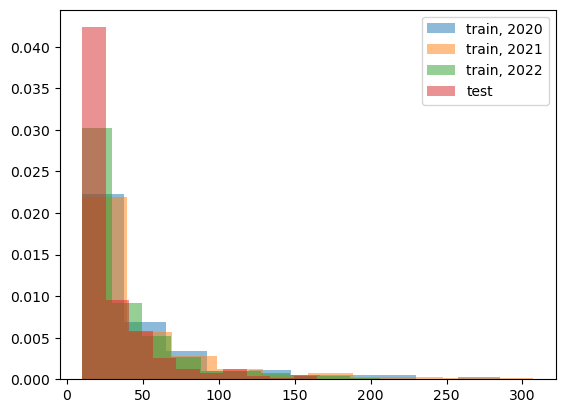

In [24]:
# histogram of units for train and test data
plt.hist(train_data[train_data['year'] == 2020]['units'], bins=10, alpha=0.5, label='train, 2020', density=True)
plt.hist(train_data[train_data['year'] == 2021]['units'], bins=10, alpha=0.5, label='train, 2021', density=True)
plt.hist(train_data[train_data['year'] == 2022]['units'], bins=10, alpha=0.5, label='train, 2022', density=True)
plt.hist(test_data['units'], bins=10, alpha=0.5, label='test', density=True)

plt.legend()

____

In [25]:
# using num to priority dict, make priority column
train_data['district'] = train_data['num'].map(num_to_priority)
test_data['district'] = test_data['num'].map(num_to_priority)

In [26]:
test_data['units'] = test_data['num'].map(num_to_units_2023)

____

### 저장

In [27]:
train_data.columns

Index(['is_dummy', 'num', 'year', 'datetime', 'temp', 'humid', 'wind', 'rain',
       'tchi', 'units', 'sum_qctr', 'sum_load', 'n_mean_load', 'elec', 'date',
       'avg_load', 'holiday', 'x', 'y', 'lon', 'lat', 'datetime_mid_tzKST',
       'altitude_raw', 'altitude', 'dci', 'hi', 'wchi', 'atemp', 'district'],
      dtype='object')

In [28]:
test_data.columns

Index(['is_dummy', 'num', 'year', 'datetime', 'temp', 'humid', 'wind', 'rain',
       'tchi', 'date', 'holiday', 'x', 'y', 'lon', 'lat', 'datetime_mid_tzKST',
       'altitude_raw', 'altitude', 'dci', 'hi', 'wchi', 'atemp', 'units',
       'district'],
      dtype='object')

In [29]:
assert False

AssertionError: 

In [ ]:
test_save_columns = ['is_dummy', 'num', 'lat', 'lon', 'district', 'units', 'year', 'datetime', 'holiday',\
                     'altitude', 'temp', 'humid', 'wind', 'rain', 'tchi', 'dci', 'hi', 'wchi', 'atemp']

train_save_columns = test_save_columns + ['sum_qctr', 'sum_load', 'avg_load', 'n_mean_load', 'elec']

train_data = train_data[train_save_columns]
test_data = test_data[test_save_columns]


if SAVE:
    train_data.to_csv(Path(asset_path, '01_electric_train_features.csv'), index=False)
    test_data.to_csv(Path(asset_path, '01_electric_test_features.csv'), index=False)